In [1]:
from icecream import ic
from pyforest import *
import pyforest; pyforest.disable_javascript_update()
from lovely_numpy import lo

In [2]:
import random
import math
import re
import itertools
from collections import Counter
from functools import partial
from tqdm import trange
import pickle

# Move utils to head.
import hu_utils
import importlib
hu_utils = importlib.reload(hu_utils)
from sklearn.utils import shuffle

from skopt.learning import RandomForestRegressor as opt_RF
from skopt.learning import ExtraTreesRegressor as opt_ET
import sklearn.gaussian_process as gp
plt.style.use('classic')
import seaborn as sns
# sns.set_style('whitegrid')
import plt_configs; importlib.reload(plt_configs)

import shap

<IPython.core.display.Javascript object>

In [3]:
!pip install openpyxl


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
from sklearn.model_selection import (
    cross_validate, train_test_split
)
from sklearn.ensemble import RandomForestRegressor

In [4]:
df = pd.read_csv('data/df_316.csv', index_col=0)

In [5]:
df

,Nucleophilic-HEA,Hydrophobic-BA,Acidic-CBEA,Cationic-ATAC,Aromatic-PEA,Amide-AAm,Glass (kPa)_max
0,0.52,0.20,0.09,0.19,0.00,0.00,22.36
1,0.42,0.41,0.17,0.00,0.00,0.00,12.57
2,0.54,0.11,0.18,0.17,0.00,0.00,10.93
3,0.22,0.20,0.09,0.17,0.32,0.00,126.82
4,0.12,0.41,0.19,0.19,0.09,0.00,109.27
...,...,...,...,...,...,...,...
311,0.00,0.19,0.00,0.36,0.45,0.00,152.87
312,0.00,0.35,0.00,0.32,0.24,0.09,157.85
313,0.00,0.62,0.00,0.03,0.35,0.00,177.44
314,0.00,0.61,0.00,0.04,0.35,0.00,196.46


In [6]:
x_columns = ['Nucleophilic-HEA', 'Hydrophobic-BA', 'Acidic-CBEA', 'Cationic-ATAC',
       'Aromatic-PEA', 'Amide-AAm']
y_column = 'Glass (kPa)_max'

In [7]:
X = df.loc[:, x_columns]
y = df.loc[:, y_column]

In [8]:
X.shape, y.shape

((316, 6), (316,))

## Fit part.

In [9]:
### Do GridSearchCV for top 8 models
np.random.seed(0)
random.seed(0)
rs = 929

rmse_dict = dict()

In [10]:
# xgb ranges
range_depth = [6, 7, 8]
range_subsample = [0.8, 0.9, 1]
range_colsample = [0.8, 0.9, 1]
range_lr = [0.1, 0.05]

# Common ranges


# For debugging
debug = False
# debug_run = True
if debug:
    # xgb ranges
    range_depth = [3,4]
    range_subsample = [0.9, 1]
    range_colsample = [0.9, 1]
    range_lr = [0.1, 0.05]
ntree = 500

In [42]:
X.head()

,Nucleophilic-HEA,Hydrophobic-BA,Acidic-CBEA,Cationic-ATAC,Aromatic-PEA,Amide-AAm
0,0.52,0.20,0.09,0.19,0.00,0.00
1,0.42,0.41,0.17,0.00,0.00,0.00
2,0.54,0.11,0.18,0.17,0.00,0.00
3,0.22,0.20,0.09,0.17,0.32,0.00
4,0.12,0.41,0.19,0.19,0.09,0.00


### Utils

In [11]:
import hu_utils
import importlib
hu_utils = importlib.reload(hu_utils)
from sklearn.utils import shuffle

# ic(plt.rcParams['mathtext.default'])
# for k in plt.rcParams:
#     if k.find('tick')!=-1:
#         ic(k ,plt.rcParams[k])

### rf_cv, best_rf_cv, CV object setups and .fit()

In [12]:
rf_cv = hu_utils.setup_gridsearch_model('RFRsk')
rf_cv.fit(X, y)
ic(rf_cv.best_params_)

ic| rf_cv.best_params_: {'max_features': 'sqrt', 'max_leaf_nodes': 70, 'min_samples_leaf': 1}


{'max_features': 'sqrt', 'max_leaf_nodes': 70, 'min_samples_leaf': 1}

RMSE 14.267 (sd: 0.446, min:13.182, max:14.710, det:0.963) ... train
RMSE 32.122 (sd: 7.293, min:22.326, max:49.064, det:0.790) ... test


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


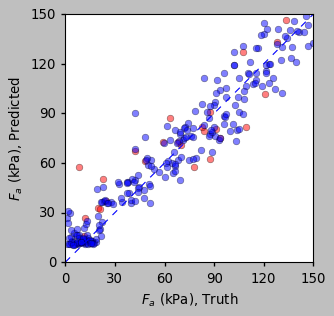

In [13]:
best_rf_cv = hu_utils.BestEstimatorCV(estimator=rf_cv.best_estimator_,
                                      X=X,
                                      y=y,
                                      cv=10)
# best_rf_cv.output_stats_difference()
best_rf_cv.output_stats()
best_rf_cv.plot_hold_out('hold_out_rf_316')
# best_rf_cv.plot_importance(X.columns, topk=6, fname='hold_out_rf_feature_importance')

In [14]:
rmse_dict['RFR'] = best_rf_cv.output_stats()[0]

RMSE 14.267 (sd: 0.446, min:13.182, max:14.710, det:0.963) ... train
RMSE 32.122 (sd: 7.293, min:22.326, max:49.064, det:0.790) ... test


### SHAP plot for RFR

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


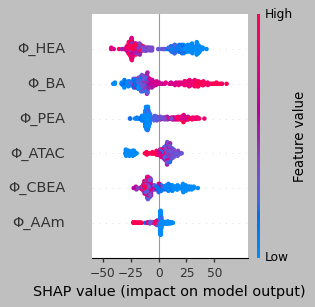

In [25]:
shap.initjs()
explainer = shap.TreeExplainer(rf_cv.best_estimator_)
X.columns = ['Φ_HEA','Φ_BA','Φ_CBEA','Φ_ATAC','Φ_PEA','Φ_AAm']
shap_values = explainer.shap_values(X)
# shap.summary_plot(shap_values, X, plot_type='bar') # Summary bar plot
shap.summary_plot(shap_values, X, show=False, plot_size=(4,4)) # Summary bee-swarm plot
# shap.summary_plot(shap_values, X, plot_type='layered_violin') # Summary bee-swarm plot
# shap.dependence_plot(3, shap_values, X)
# shap.force_plot(explainer.expected_value, shap_values, X)
# shap.plots.waterfall(explainer)
plt.xticks([-50,-25,0,25,50])
plt.savefig('shap/shap_summary_plot_316.pdf')



In [48]:
# X.iloc[:,3]

output_force_plot = shap.force_plot(explainer.expected_value, shap_values, X, show=False)
file ='force_plot.html'
shap.save_html(file, output_force_plot)
# lo(shap_values)
# lo(explainer.expected_value)

In [116]:
hu_utils.plot_shap_waterfall(rf_cv.best_estimator_, X, figsize=(4,4))

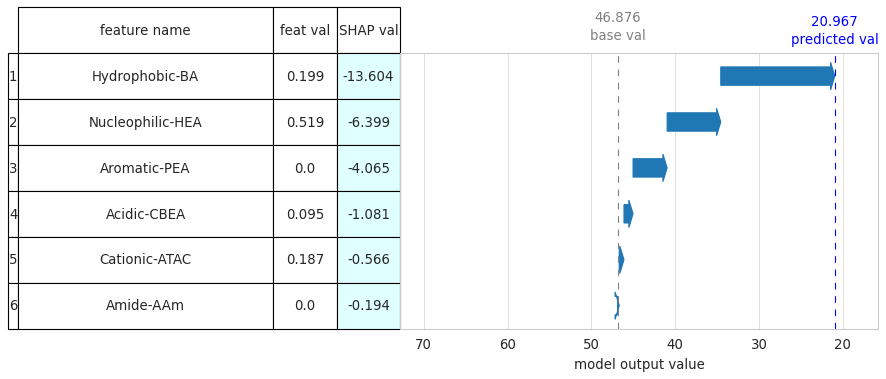

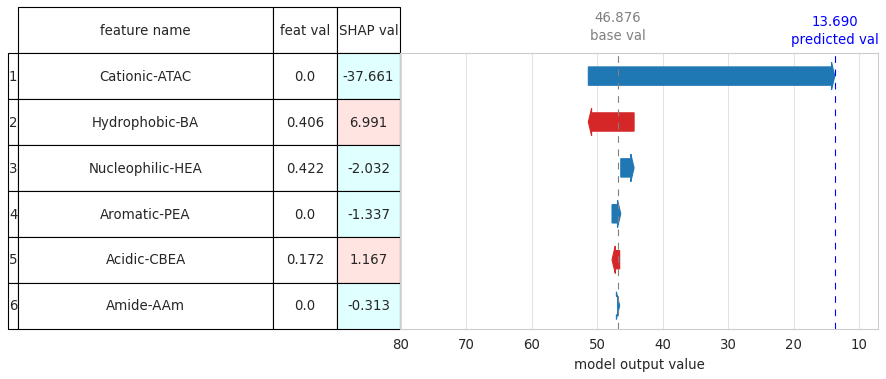

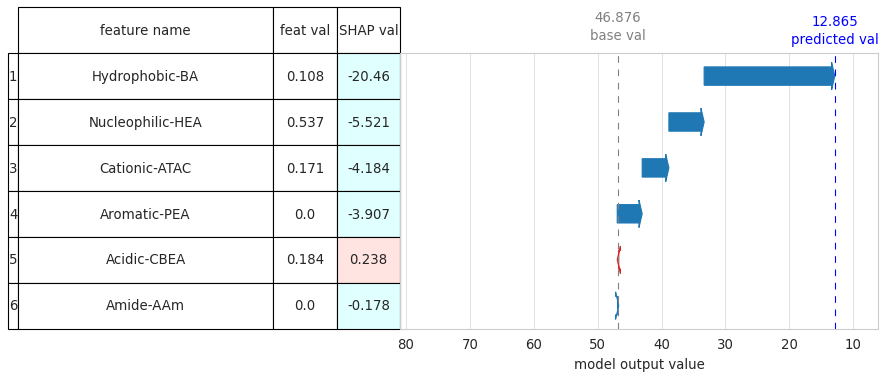

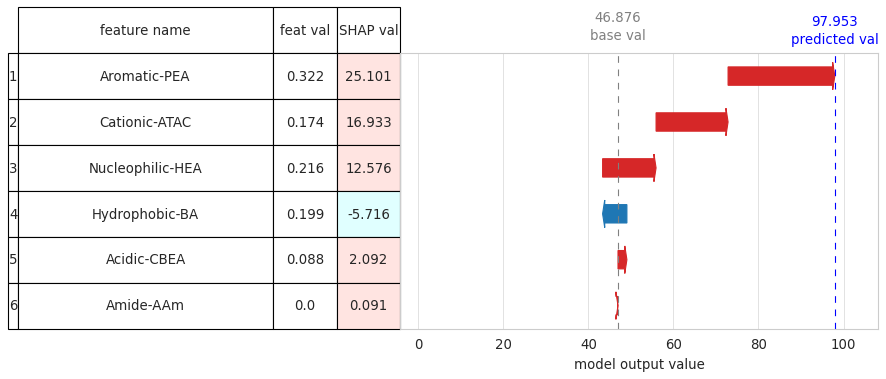

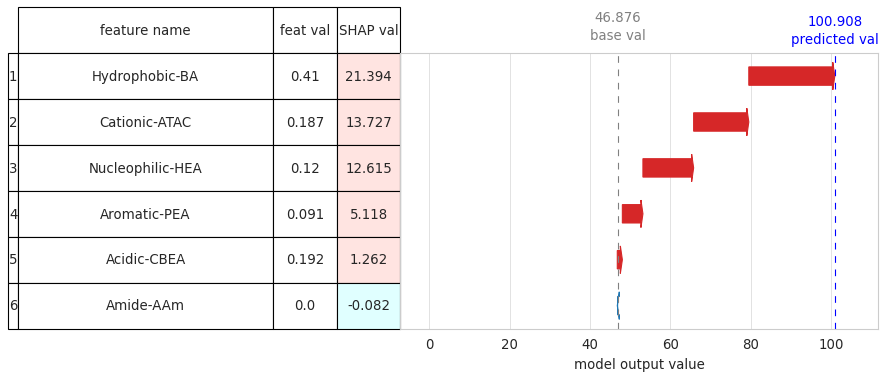

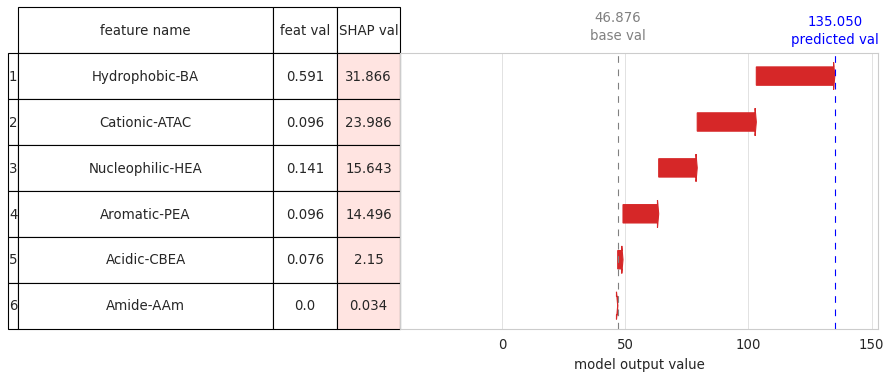

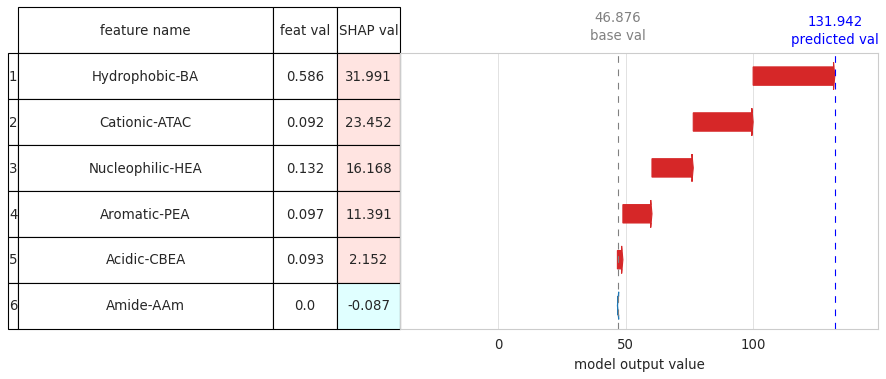

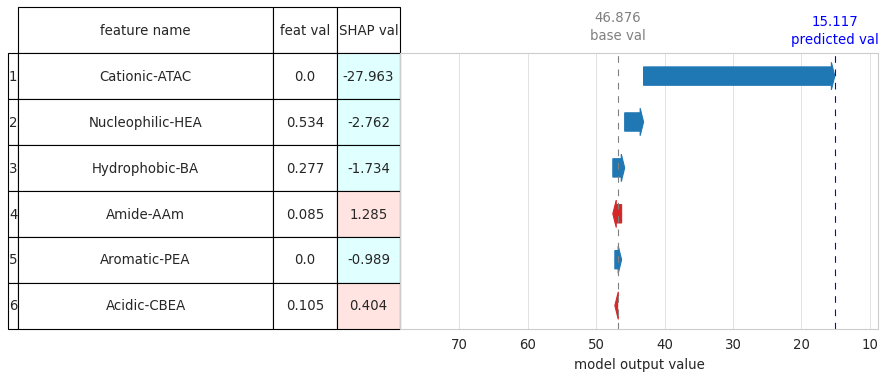

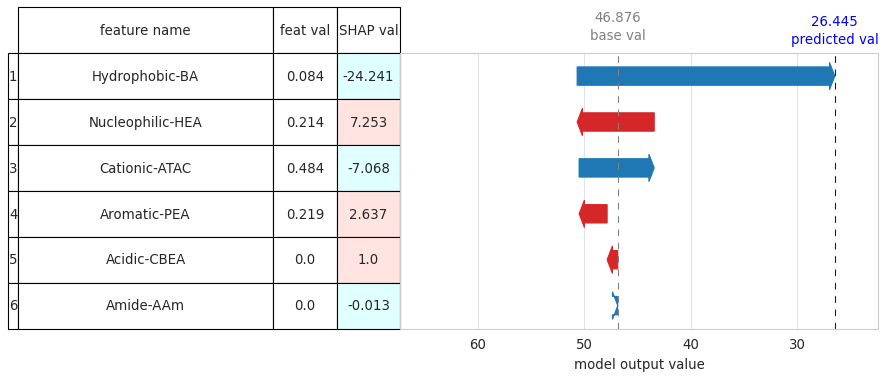

In [52]:
PATH = 'shap/'
import os
os.makedirs(PATH, exist_ok = True)
base_val = y.mean()
for i in range(5):
    cand_name = X.index[i]
    tmp = X.iloc[i, :].astype('float').to_frame()
    tmp.columns = ['val']
    tmp['shap'] = shap_values[i]
    hu_utils.plot_topshap(tmp, base_val, k=6, figsize = (17, 5), save=True) # Revoke the plot_topSHAP()
    plt.savefig(PATH + f'shap_{i}.pdf', bbox_inches='tight')

for i in [41, 106, 179, 85]:
    cand_name = X.index[i]
    tmp = X.iloc[i, :].astype('float').to_frame()
    tmp.columns = ['val']
    tmp['shap'] = shap_values[i]
    hu_utils.plot_topshap(tmp, base_val, k=6, figsize = (17, 5), save=True) # Revoke the plot_topSHAP()
    plt.savefig(PATH + f'shap_{i}.pdf', bbox_inches='tight')

### ETR

ic| etr_cv.best_params_: {'bootstrap': True,
                          'max_features': 1.0,
                          'max_leaf_nodes': 70,
                          'min_samples_leaf': 2}


RMSE 21.490 (sd: 0.659, min:19.987, max:22.192, det:0.915) ... train
RMSE 31.715 (sd: 7.587, min:21.585, max:48.509, det:0.793) ... test


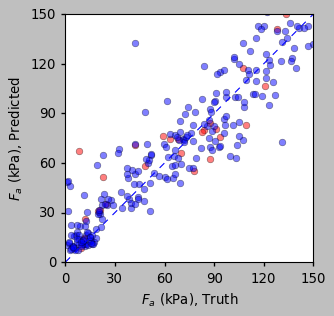

In [15]:
etr_cv = hu_utils.setup_gridsearch_model('ETR')
etr_cv.fit(X, y)
ic(etr_cv.best_params_)
best_etr_cv = hu_utils.BestEstimatorCV(estimator=etr_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
rmse_dict['ETR'] = best_etr_cv.output_stats()[0]
best_etr_cv.plot_hold_out('hold_out_etr_316')


ic| xgb_cv.best_params_: {'colsample_bytree': 0.8,
                          'learning_rate': 0.05,
                          'max_depth': 6,
                          'n_estimators': 200,
                          'subsample': 0.8}


RMSE 4.314 (sd: 0.313, min:3.836, max:4.808, det:0.997) ... train
RMSE 33.354 (sd: 6.547, min:24.773, max:48.819, det:0.776) ... test


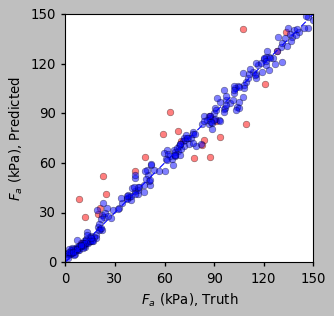

In [16]:
# Need 13 mins.
xgb_cv = hu_utils.setup_gridsearch_model('XGB')
xgb_cv.fit(X, y)
ic(xgb_cv.best_params_)
best_xgb_cv = hu_utils.BestEstimatorCV(estimator=xgb_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
rmse_dict['XGB'] = best_xgb_cv.output_stats()[0]
best_xgb_cv.plot_hold_out(f'hold_out_xgb_316')


ic| lasso_cv.best_params_: {'alpha': 0.1}


RMSE 41.677 (sd: 1.005, min:39.115, max:42.819, det:0.681) ... train
RMSE 41.821 (sd: 8.297, min:30.613, max:61.399, det:0.655) ... test


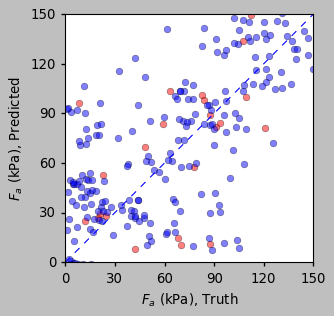

In [17]:
lasso_cv = hu_utils.setup_gridsearch_model('LASSO')
lasso_cv.fit(X, y)
ic(lasso_cv.best_params_)
best_lasso_cv = hu_utils.BestEstimatorCV(estimator=lasso_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
rmse_dict['Lasso'] = best_lasso_cv.output_stats()[0]
best_lasso_cv.plot_hold_out('hold_out_lasso_316')


ic| ridge_cv.best_params_: {'alpha': 1.0}


RMSE 41.987 (sd: 0.999, min:39.432, max:43.133, det:0.676) ... train
RMSE 41.917 (sd: 8.420, min:29.867, max:62.442, det:0.654) ... test


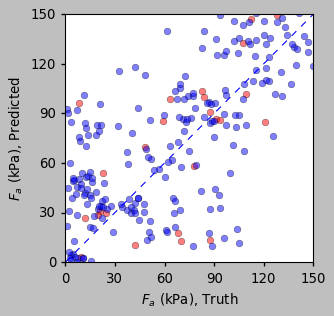

In [18]:
ridge_cv = hu_utils.setup_gridsearch_model('RIDGE')
ridge_cv.fit(X, y)
ic(ridge_cv.best_params_)
best_ridge_cv = hu_utils.BestEstimatorCV(estimator=ridge_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
best_ridge_cv.plot_hold_out(f'hold_out_ridge_316')
rmse_dict['Ridge'] = best_ridge_cv.output_stats()[0]


ic| krr_cv.best_params_: {'alpha': 0.01, 'gamma': 1.0}


RMSE 29.960 (sd: 0.994, min:27.233, max:30.736, det:0.835) ... train
RMSE 32.218 (sd: 7.144, min:25.002, max:50.613, det:0.791) ... test


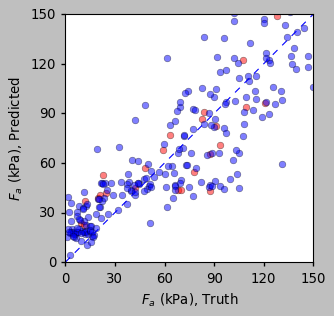

In [19]:
krr_cv = hu_utils.setup_gridsearch_model('KRR')
krr_cv.fit(X, y)
ic(krr_cv.best_params_)
best_krr_cv = hu_utils.BestEstimatorCV(estimator=krr_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
rmse_dict['KRR'] = best_krr_cv.output_stats()[0]
best_krr_cv.plot_hold_out(f'hold_out_krr_316')


ic| svr_cv.best_params_: {'C': 10000.0, 'epsilon': 1.0, 'gamma': 1.0}


RMSE 29.065 (sd: 0.960, min:26.525, max:29.782, det:0.845) ... train
RMSE 31.360 (sd: 7.996, min:23.744, max:51.364, det:0.799) ... test


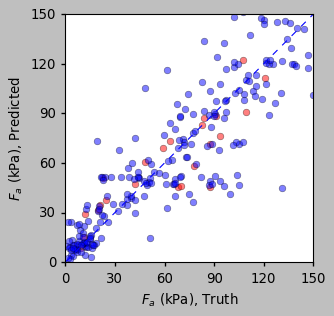

In [20]:
svr_cv = hu_utils.setup_gridsearch_model('SVR')
svr_cv.fit(X, y)
ic(svr_cv.best_params_)
best_svr_cv = hu_utils.BestEstimatorCV(estimator=svr_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
rmse_dict['SVR'] = best_svr_cv.output_stats()[0]
best_svr_cv.plot_hold_out(f'hold_out_svr_316')


ic| knn_cv.best_params_: {'n_neighbors': 8, 'p': 2}


RMSE 31.271 (sd: 0.874, min:29.140, max:32.588, det:0.821) ... train
RMSE 34.529 (sd: 6.720, min:25.233, max:49.927, det:0.761) ... test


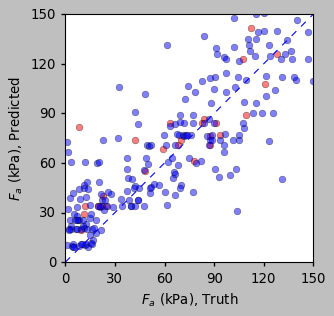

In [21]:
knn_cv = hu_utils.setup_gridsearch_model('KNN')
knn_cv.fit(X, y)
ic(knn_cv.best_params_)
best_knn_cv = hu_utils.BestEstimatorCV(estimator=knn_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
rmse_dict['KNN'] = best_knn_cv.output_stats()[0]
best_knn_cv.plot_hold_out(f'hold_out_knn_316')


In [193]:
# dummy_cv = hu_utils.setup_gridsearch_model('DUM')
# dummy_cv.fit(X, y)
# ic(dummy_cv.best_params_)
# best_dummpy_cv = hu_utils.BestEstimatorCV(estimator=dummy_cv.best_estimator_,
#                                        X=X,
#                                        y=y,
#                                        cv=10)
# best_dummpy_cv.output_stats()
# best_dummpy_cv.plot_hold_out(f'hold_out_dummy')


ic| dummy_cv.best_params_: {'strategy': 'mean'}


RMSE 36.054 (sd: 0.563, min:35.151, max:37.091, det:0.000) ... train
RMSE 36.111 (sd: 5.271, min:25.242, max:43.637, det:-0.190) ... test


In [32]:

# ret = {}
# ret[ "trn_mean" ] = 21.236  # 5 fold mean. It's different from the overal rmse.
# ret["trn_std"] = 3.455
# ret["tes_mean"] = 22.808
# ret["tes_std"] = 5.312
# rmse_dict['TabNet'] = ret

/home/user/miniconda3/envs/deep/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/user/miniconda3/envs/deep/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 5 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/user/miniconda3/envs/deep/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/user

RMSE 27.268 (sd: 2.457, min:20.276, max:29.397, det:0.863) ... train
RMSE 31.746 (sd: 7.575, min:22.635, max:51.074, det:0.798) ... test


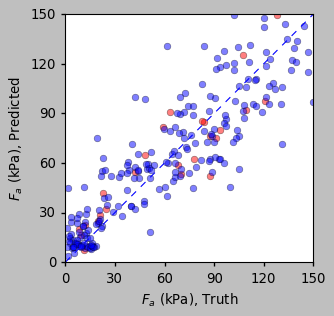

In [22]:
gp_cv = hu_utils.setup_gridsearch_model('GP')
gp_cv.fit(X, y)
ic(gp_cv.best_params_)
best_gp_cv = hu_utils.BestEstimatorCV(estimator=gp_cv.best_estimator_,
                                       X=X,
                                       y=y,
                                       cv=10)
# best_gp_cv.output_stats()
rmse_dict['GP'] = best_gp_cv.output_stats()[0]
best_gp_cv.plot_hold_out(f'hold_out_gp_316')


In [23]:
# Serialization.
with open('data/rmse_dict_316.pkl', 'wb') as f:
    pickle.dump(rmse_dict, f)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


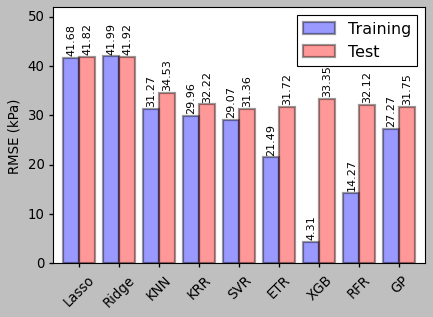

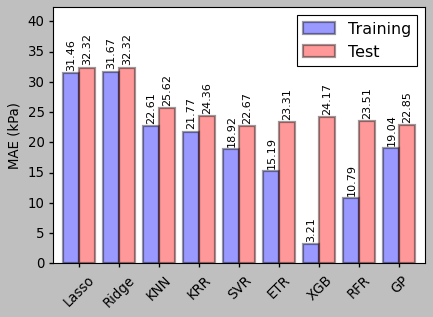

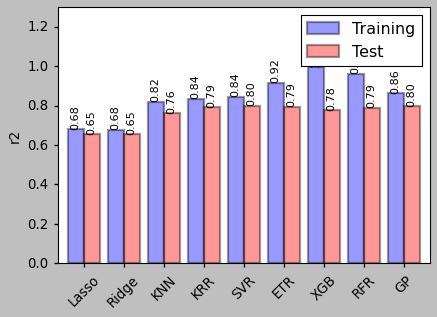

In [4]:
import os
from_scratch = os.path.exists('data/rmse_dict_316.pkl')
if not from_scratch:
    hu_utils.plot_compared_methods_rmse_316(rmse_dict, type='rmse', updated=True)
    hu_utils.plot_compared_methods_rmse_316(rmse_dict, type='mae', updated=True)
    hu_utils.plot_compared_methods_rmse_316(rmse_dict, type='r2', updated=True)
else:
    with open('data/rmse_dict_316.pkl', 'rb') as f:
        rmse_dict = pickle.load(f)
    hu_utils.plot_compared_methods_rmse_316(rmse_dict, type='rmse', updated=True)
    hu_utils.plot_compared_methods_rmse_316(rmse_dict, type='mae', updated=True)
    hu_utils.plot_compared_methods_rmse_316(rmse_dict, type='r2', updated=True)
